Note : Remove the warm-up time for any experiments, including our project cause if we keep it, it could skew the results very much

In [46]:
import os
import sys
from contextlib import contextmanager, redirect_stdout
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np
import simpy
from matplotlib.axes import Axes
from matplotlib.figure import Figure

RNG = np.random.default_rng(seed=0) 


@contextmanager
def suppress_print():
    """Temporarily disable print statements."""
    with redirect_stdout(open(os.devnull, "w")):
        yield

# 1. Closed Queuing network simulation (17 pt)

Build a simulator to capture the following system and answer the questions below. A total of N=40 jobs circulate in different parts of the systems: CPU, disk, and resting area. There is one CPU and two disks, one slow and one fast. Each job starts at the CPU station and takes an average of 2 seconds. After CPU, a job fetches the data from the disk, needing an average of 3000 disk cycles. There are two possible choices of disks, fast and slow, which have a speed of 1000 cycles per second and 100 cycles per seconds, respectively. After the disk station, the job can rest for 15 seconds on average. The figure below gives an overview of the system:

The choices of distributions are up to you. You are welcomed to try different distributions to answer the following questions and assess the impact of different variants.


### Distribution: Exponential

In [ ]:
class ClosedQueuingNet:
    """
    Closed queuing network with:
    - CPU (1 server)
    - Fast disk (1 server)
    - Slow disk (1 server)
    - Rest area (infinite server)
    - N circulating jobs
    - No warmup: all statistics counted from t = 0
    """

    def __init__(
        self,
        env: simpy.Environment,
        strategy: str,               # <-- ADD THIS
        N: int = 40,
        mu_cpu: float = 2.0,
        disk_cycles: float = 3000.0,
        speed_fast_1: float = 1000.0,
        speed_fast_2: float = 1000.0,
        speed_slow: float = 100.0,
        mu_rest: float = 15.0,
):
        self.env = env
        self.strategy = strategy     # <-- STORE STRATEGY
        self.N = N # number of jobs


        # Mean times
        self.mu_cpu = mu_cpu
        self.mu_disk_fast_1 = disk_cycles / speed_fast_1   # 3000 / 1000 = 3s
        self.mu_disk_fast_2 = disk_cycles / speed_fast_2   # 3000 / 1000 = 3s
        self.mu_disk_slow = disk_cycles / speed_slow   # 3000 / 100 = 30s
        self.mu_rest = mu_rest

        # Resources
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.disk_fast_1 = simpy.Resource(self.env, capacity=1)
        self.disk_fast_2 = simpy.Resource(self.env, capacity=1)
        self.disk_slow = simpy.Resource(self.env, capacity=1)

        # Statistics (no warmup)
        self.completed_cycles = 0
        self.sum_cycle_times = 0.0
        self.response_time_acc = 0.

        self.cpu_busy = 0.0
        self.disk_fast_1_busy = 0.0
        self.disk_fast_2_busy = 0.0
        self.disk_slow_busy = 0.0

    def job(self, job_id: int) -> Generator:
        """
        A single circulating job:
        CPU -> Disk(fast/slow) -> Rest -> repeat
        """
        while True:
            cycle_start = self.env.now

            # CPU 
            req = self.cpu.request()
            yield req
            start = self.env.now
            service = RNG.exponential(scale=self.mu_cpu)
            yield self.env.timeout(service)
            end = self.env.now
            self.cpu.release(req)

            self.cpu_busy += (end - start)

            # Disk 

            """  #Code for questions 1 & 2 (1 fast disk)         
            if self.strategy == "random":
                # Strategy 1: random routing
                speed = RNG.choice(["fast", "slow"])
                if speed == "fast":
                    disk = self.disk_fast
                    mean = self.mu_disk_fast
                    busy_attr = "disk_fast_busy"
                else:
                    disk = self.disk_slow
                    mean = self.mu_disk_slow
                    busy_attr = "disk_slow_busy"

            elif self.strategy == "queue_aware":
                # Strategy 2: queue-aware routing
                load_fast = len(self.disk_fast.queue) + self.disk_fast.count
                load_slow = len(self.disk_slow.queue) + self.disk_slow.count

                if load_fast <= load_slow:
                    disk = self.disk_fast
                    mean = self.mu_disk_fast
                    busy_attr = "disk_fast_busy"
                else:
                    disk = self.disk_slow
                    mean = self.mu_disk_slow
                    busy_attr = "disk_slow_busy"

         """
            # Code for questions 3 & 4 (2 fast disks)
            
            # Disk 

            if self.strategy == "random":
                # Strategy 1: random routing
                speed = RNG.choice(["fast1", "fast2", "slow"])

                if speed == "fast1":
                    disk = self.disk_fast_1
                    mean = self.mu_disk_fast_1
                    busy_attr = "disk_fast_1_busy"

                elif speed == "fast2":
                    disk = self.disk_fast_2
                    mean = self.mu_disk_fast_2
                    busy_attr = "disk_fast_2_busy"

                else:
                    disk = self.disk_slow
                    mean = self.mu_disk_slow
                    busy_attr = "disk_slow_busy"


            elif self.strategy == "queue_aware":
                # Strategy 2: queue-aware routing

                load_fast_1 = len(self.disk_fast_1.queue) + self.disk_fast_1.count
                load_fast_2 = len(self.disk_fast_2.queue) + self.disk_fast_2.count
                load_slow   = len(self.disk_slow.queue) + self.disk_slow.count

                # pick least-loaded disk
                if load_fast_1 <= load_fast_2 and load_fast_1 <= load_slow:
                    disk = self.disk_fast_1
                    mean = self.mu_disk_fast_1
                    busy_attr = "disk_fast_1_busy"

                elif load_fast_2 <= load_slow:
                    disk = self.disk_fast_2
                    mean = self.mu_disk_fast_2
                    busy_attr = "disk_fast_2_busy"

                else:
                    disk = self.disk_slow
                    mean = self.mu_disk_slow
                    busy_attr = "disk_slow_busy"

            else:
                raise ValueError(f"Unknown routing strategy: {self.strategy}")




            req = disk.request()
            yield req
            start = self.env.now
            service = RNG.exponential(scale=mean)
            yield self.env.timeout(service)
            end = self.env.now
            disk.release(req)

            if busy_attr == "disk_fast_1_busy":
                self.disk_fast_1_busy += (end - start)
            elif busy_attr == "disk_fast_2_busy":
                self.disk_fast_2_busy += (end - start)
            else:
                self.disk_slow_busy += (end - start)

            # ===== Rest =====
            rest_time = RNG.exponential(scale=self.mu_rest)
            yield self.env.timeout(rest_time)

            # ===== Cycle complete =====
            self.completed_cycles += 1
            self.sum_cycle_times += (self.env.now - cycle_start)

            # Responce time
            self.response_time_acc += self.env.now - cycle_start
    
    def run(self, t: float, verbose: bool = True):
        """
        Run the system for total time t (no warmup).
        """

        # Start all N circulating job processes
        for j in range(self.N):
            self.env.process(self.job(j))

        # Run until the end of simulation
        self.env.run(until=t)

        # ===== Statistics =====
        throughput = self.completed_cycles / t # throughput = self.N / self.env.now
        avg_cycle_time = self.sum_cycle_times / self.completed_cycles
        responce_time = self.response_time_acc / self.completed_cycles

        util_cpu = self.cpu_busy / t
        util_fast_1 = self.disk_fast_1_busy / t
        util_fast_2 = self.disk_fast_2_busy / t
        util_slow = self.disk_slow_busy / t


        if verbose:
            print(f"=== Results (t = {t}) ===")
            print(f"Completed cycles: {self.completed_cycles}")
            print(f"Throughput (jobs/s): {throughput:.6f}")
            print(f"Responce time: {responce_time:.6f}")
            print(f"CPU utilization: {util_cpu:.6f}")
            print(f"Fast disk 1 utilization: {util_fast_1:.6f}")
            print(f"Fast disk 2 utilization: {util_fast_2:.6f}")
            print(f"Slow disk utilization: {util_slow:.6f}")

            print("===============================")

        return {
            "completed_cycles": self.completed_cycles,
            "throughput": throughput,
            "response_time": responce_time,
            "cpu_util": util_cpu,
            "fast_1_util": util_fast_1,
            "fast_2_util": util_fast_2,
            "slow_disk_util": util_slow,
        }

    def run_with_trace(self, t: float, sample_dt: float = 100.0, verbose: bool = False): 
        # This function was made for the purpose of creating the upcoming plots
        """
        Run the simulation and record cumulative metrics at regular intervals (sample_dt).
        Returns a dict with arrays for times and metrics (throughput, response_time, utilizations).
        """
        # Start all N circulating job processes (if not started yet)
        for j in range(self.N):
            self.env.process(self.job(j))

        times = []
        throughputs = []
        response_times = []
        cpu_utils = []
        fast_1_utils = []
        fast_2_utils = []
        slow_utils = []

        next_t = sample_dt
        while self.env.now < t:
            self.env.run(until=min(next_t, t))
            now = self.env.now
            times.append(now)

            throughputs.append(self.completed_cycles / now if now > 0 else 0.0)
            response_times.append(
                (self.response_time_acc / self.completed_cycles) if self.completed_cycles > 0 else float("nan")
            )
            cpu_utils.append(self.cpu_busy / now if now > 0 else 0.0)
            fast_1_utils.append(self.disk_fast_1_busy / now if now > 0 else 0.0)
            fast_2_utils.append(self.disk_fast_2_busy / now if now > 0 else 0.0)
            slow_utils.append(self.disk_slow_busy / now if now > 0 else 0.0)

            next_t += sample_dt

        if verbose:
            print(f"Collected {len(times)} samples up to t={t}")

        return {
            "times": np.array(times),
            "throughput": np.array(throughputs),
            "response_time": np.array(response_times),
            "cpu_util": np.array(cpu_utils),
            "fast_1_util": np.array(fast_1_utils),
            "fast_2_util": np.array(fast_2_utils),
            "slow_disk_util": np.array(slow_utils),
        }



In [48]:
# The purpose of this function is to run the two strategies in the same time and have both results displayed 
# instead commenting/uncommenting each strategy everytime we want to use one of them
# It's defined outside the class because it (function) calls it (class) in it (function)

def run_both_strategies(t: float): 
        results = {}

        for strategy in ["random", "queue_aware"]:
            env = simpy.Environment()
            sim = ClosedQueuingNet(env, strategy=strategy)

            with suppress_print():  # optional
                res = sim.run(t, verbose=False)

            results[strategy] = res

        # Print side-by-side summary
        print("\n STRATEGY COMPARAISON")
        for strategy, res in results.items():
            print(f"\nStrategy: {strategy}")
            print(f"  Completed cycles: {res['completed_cycles']}")
            print(f"  Throughput (jobs/s): {res['throughput']:.6f}")
            print(f"  Response time: {res['response_time']:.6f}")
            print(f"  CPU util: {res['cpu_util']:.6f}")
            print(f"  Fast disk 1 util: {res['fast_1_util']:.6f}")
            print(f"  Fast disk 2 util: {res['fast_2_util']:.6f}")
            print(f"  Slow disk util: {res['slow_disk_util']:.6f}")



        return results



In [49]:
# IMPORTANT: NEVER RUN THISE CELLS ALONE!
# To have the same result each time for this type of code cell, run the WHOLE notebook (Run All).
# Otherwise (if you only run this cell ), you'll get a different result each time

results = run_both_strategies(t=10_000)


 STRATEGY COMPARAISON

Strategy: random
  Completed cycles: 996
  Throughput (jobs/s): 0.099600
  Response time: 373.557005
  CPU util: 0.202676
  Fast disk 1 util: 0.104021
  Fast disk 2 util: 0.104355
  Slow disk util: 0.997248

Strategy: queue_aware
  Completed cycles: 4983
  Throughput (jobs/s): 0.498300
  Response time: 80.047302
  CPU util: 0.999613
  Fast disk 1 util: 0.765829
  Fast disk 2 util: 0.609564
  Slow disk util: 0.933943


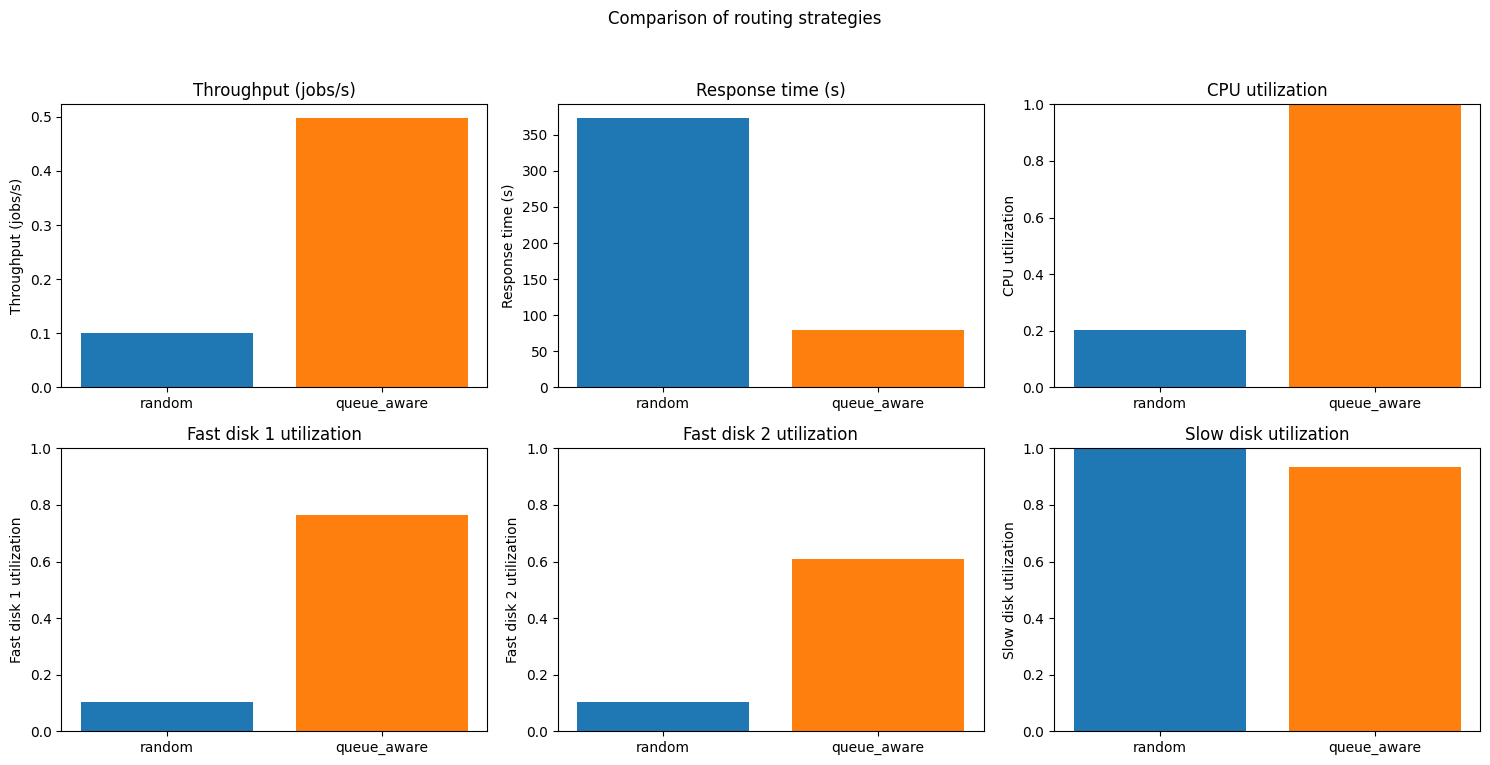

In [50]:
# Plot results of both strategies


# Metrics to plot
metrics = [
    ("throughput", "Throughput (jobs/s)"),
    ("response_time", "Response time (s)"),
    ("cpu_util", "CPU utilization"),
    ("fast_1_util", "Fast disk 1 utilization"),
    ("fast_2_util", "Fast disk 2 utilization"),
    ("slow_disk_util", "Slow disk utilization"),
]

strategies = list(results.keys())

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
colors = ["#1f77b4", "#ff7f0e"]

for ax, (metric, label) in zip(axes, metrics):
    values = [results[s][metric] for s in strategies]
    ax.bar(strategies, values, color=colors)
    ax.set_title(label)
    ax.set_ylabel(label)
    if "util" in metric:
        ax.set_ylim(0, 1)

plt.suptitle("Comparison of routing strategies")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

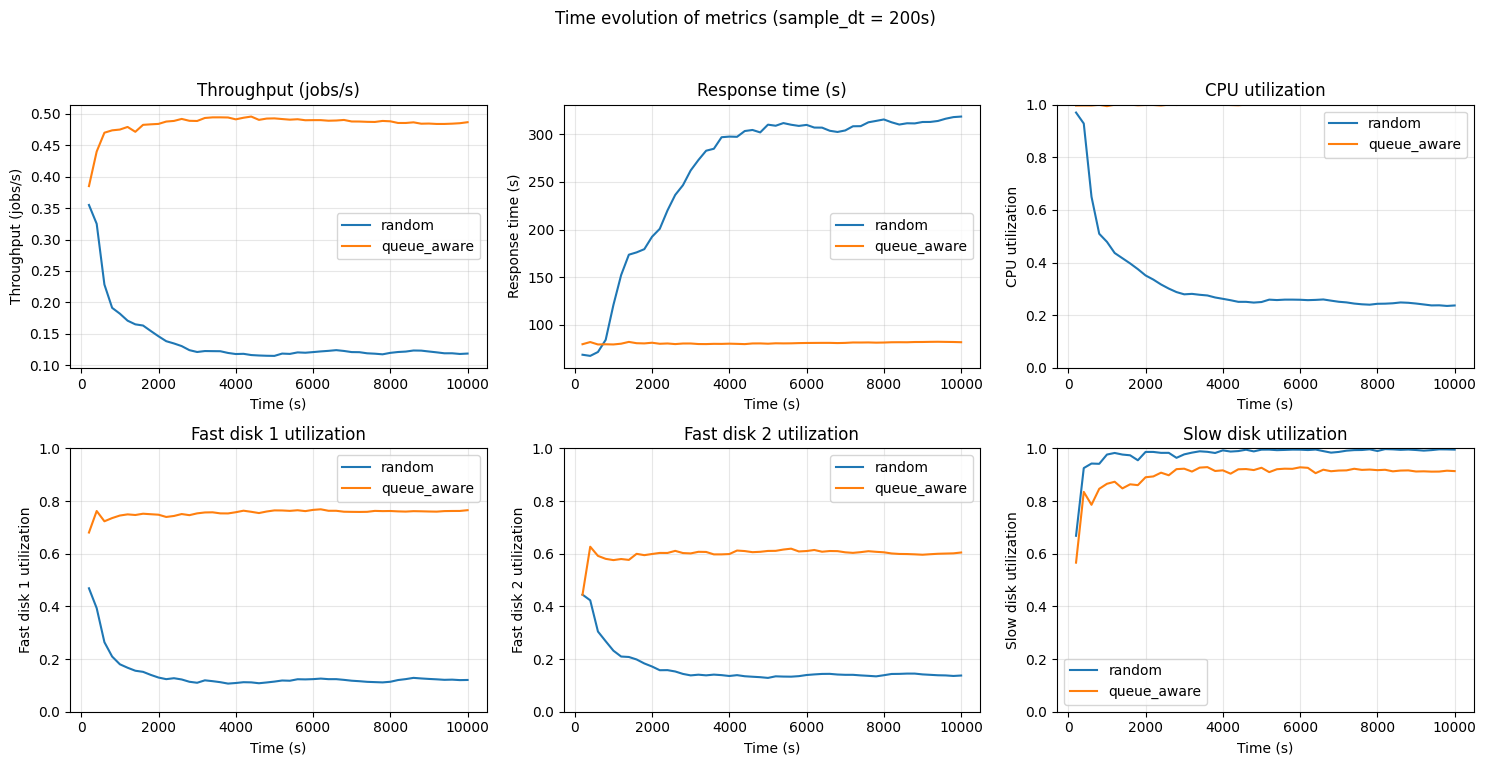

In [51]:
# Time-series traces for both strategies and line plots
# Re-run to ensure reproducible single-run traces
t = 10_000
sample_dt = 200  # sampling interval in seconds

traces = {}
for strategy in ["random", "queue_aware"]:
    env = simpy.Environment()
    sim = ClosedQueuingNet(env, strategy=strategy)
    with suppress_print():
        trace = sim.run_with_trace(t, sample_dt=sample_dt, verbose=False)
    traces[strategy] = trace

metrics = [
    ("throughput", "Throughput (jobs/s)"),
    ("response_time", "Response time (s)"),
    ("cpu_util", "CPU utilization"),
    ("fast_1_util", "Fast disk 1 utilization"),
    ("fast_2_util", "Fast disk 2 utilization"),
    ("slow_disk_util", "Slow disk utilization"),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
colors = {"random": "#1f77b4", "queue_aware": "#ff7f0e"}

for ax, (metric, label) in zip(axes, metrics):
    for strategy in traces.keys():
        ax.plot(traces[strategy]["times"], traces[strategy][metric], label=strategy, color=colors[strategy])
    ax.set_title(label)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)
    if "util" in metric:
        ax.set_ylim(0, 1)
    ax.legend()

plt.suptitle("Time evolution of metrics (sample_dt = {}s)".format(sample_dt))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1. (3p) What will be the maximal system throughput in terms of number of jobs, given two different load balancing strategies for sending jobs between the fast and slow disk? You need to come up with two load balancing strategies and compare them. 


### Answer Qu.1

- CPU time = 2 s

#### Strategy 1 : 

Random selection

Results:
  - Maximal system throughput (jobs/s): 0.065700

#### Strategy 2 : 

Queue-aware policy (routes jobs to the disk with the smallest number of jobs waiting or in service)

Results:
  - Maximal system throughput (jobs/s): 0.374100

2. (3p) What will the system throughput and average response time of a job be if a faster CPU is used? Say, CPU time is reduced to 1 seconds on average and the rest of the system remains the same.

### Answer Qu. 2

- I used both strategies to compare them (even if it was not asked in this question)
- CPU time = 1 s

#### Strategy 1 : 

Random selection

Results:
  - System throughput (jobs/s): 0.068900
  - Average responce time: 528.929249 s

#### Strategy 2 : 

Queue-aware policy (routes jobs to the disk with the smallest number of jobs waiting or in service)

Results:
  - System throughput (jobs/s): 0.372100
  - Average responce time: 105.966980 s

3. (3p) What will the system throughput and average response time of a job be if a second fast disk is added? Again, you need to compare the throughput under two different load balancing strategies.

### Answer Qu.3

- CPU time = 2 s

#### Strategy 1 : 

Random selection

Results:
  - System throughput (jobs/s): 0.099600
  - Average responce time: 373.557005 s

#### Strategy 2 : 

Queue-aware policy (routes jobs to the disk with the smallest number of jobs waiting or in service)

Results:
  - System throughput (jobs/s): 0.498300
  - Average responce time: 80.047302 s

4. (3p) What will the system throughput and average response time of a job be if a faster CPU is used and a second fast disk is added? And, you use the better load balancing strategies out of two you propose in the first question?

### Answer Qu.4
- I used both strategies to compare them (even if it was not asked in this question)
- CPU time = 1 s

#### Strategy 1 : 

Random selection

Results:
  - System throughput (jobs/s): 0.092100
  - Average responce time: 414.213516 s

#### Strategy 2 : 

Queue-aware policy (routes jobs to the disk with the smallest number of jobs waiting or in service)

Results:
  - System throughput (jobs/s): 0.711600
  - Average responce time: 55.905102 s